In [1]:
import os
import torch
from torchvision import transforms, datasets
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
data = pd.read_csv("data/captions.txt")
data.rename(columns=lambda x: x.strip(), inplace=True)
data

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [4]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string

start_token = "sos"
end_token = "eos"

def clean_caption(caption):
    if isinstance(caption, str):
        caption = start_token + " " + caption.lower()
        caption = caption.translate(str.maketrans('', '', string.punctuation))
        caption += " " + end_token  # Append the end token
    else:
        caption = start_token + " " + end_token  # Use start and end token for missing captions
    return caption


# Apply cleaning function
data['caption'] = data['caption'].apply(clean_caption)


# Create a tokenizer and fit on the captions
tokenizer = Tokenizer(num_words=5000, oov_token="<unk>")
tokenizer.fit_on_texts(data['caption'].tolist())
vocab_size = len(tokenizer.word_index) + 1

start_token_index = tokenizer.word_index[start_token]
end_token_index = tokenizer.word_index[end_token]

# Example of encoding and padding captions
encoded_captions = tokenizer.texts_to_sequences(data['caption'].tolist())
max_length = max(len(caption) for caption in encoded_captions)
padded_captions = pad_sequences(encoded_captions, maxlen=max_length, padding='post')



In [5]:
vocab_size

8832

In [6]:
class ImageCaptionDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        caption = torch.tensor(padded_captions[idx], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, caption

In [7]:
# Define the transformation
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Initialize the dataset
image_path = 'data/Images'
dataset = ImageCaptionDataset(dataframe=data, root_dir=image_path, transform=data_transform)

# DataLoader
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def previewSomeImages(loader):
    dataiter = iter(loader)
    images, captions = next(dataiter)
    images = images.numpy()  # convert images to numpy for display

    fig = plt.figure(figsize=(25, 8))
    images_to_display = 10
    for idx in np.arange(images_to_display):
        ax = fig.add_subplot(2, int(images_to_display/2), idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(captions[idx])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

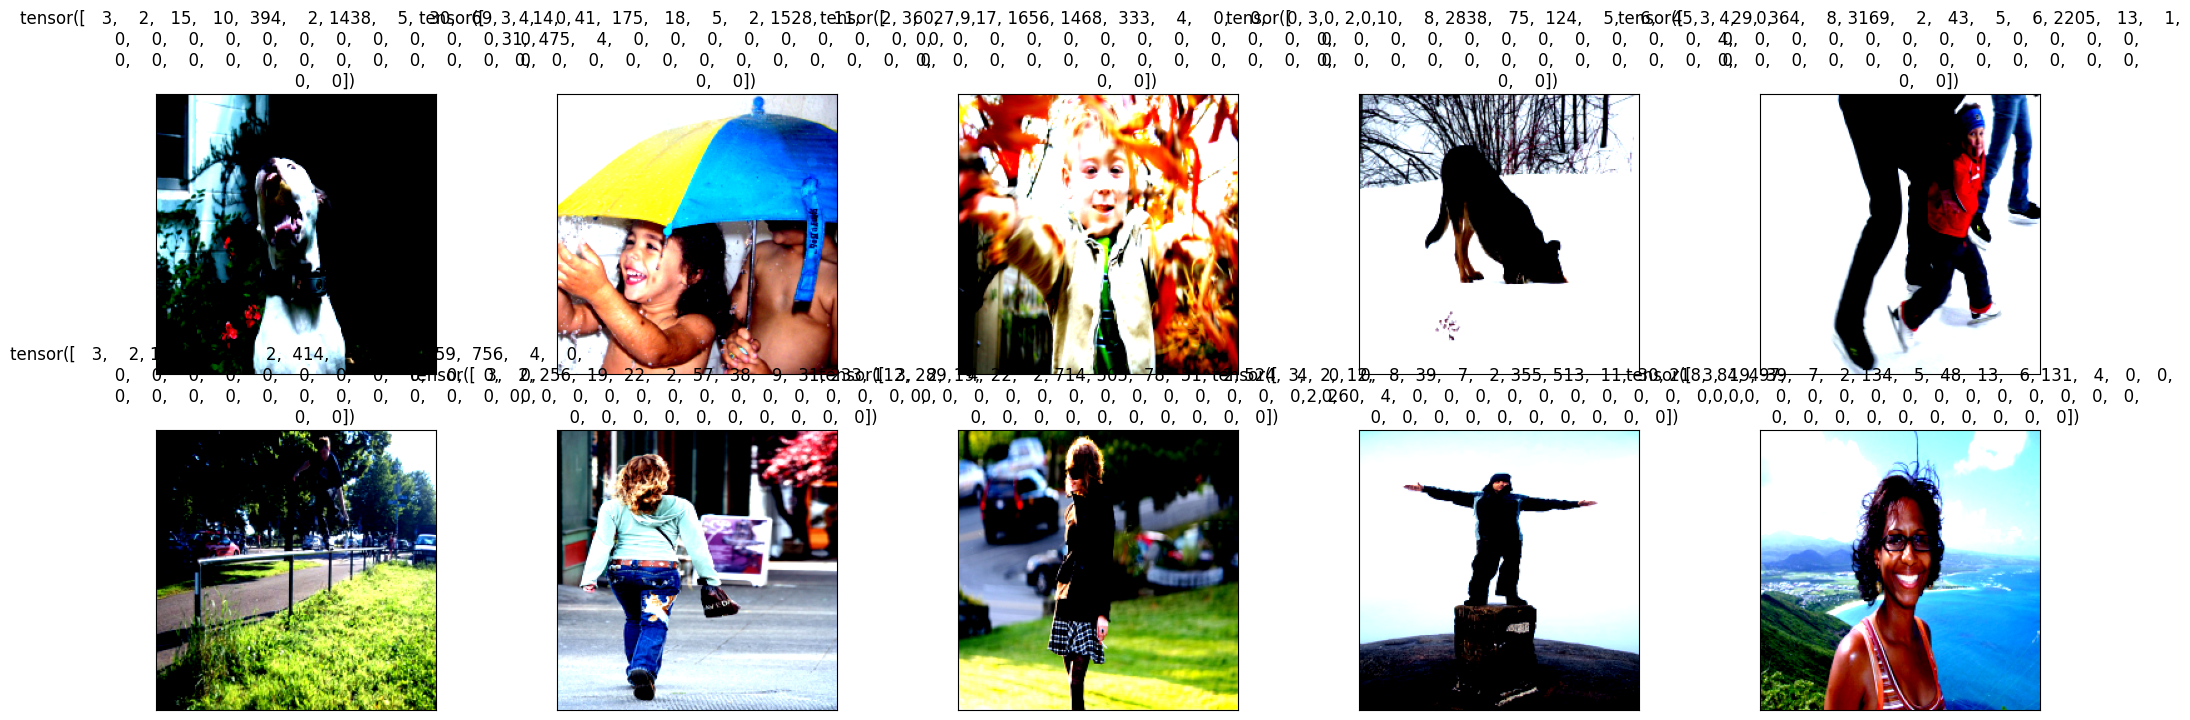

In [10]:
previewSomeImages(data_loader)


In [11]:
import torchvision

class CNNEncoder(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.cnn = torchvision.models.resnet34(pretrained=True)

    def forward(self, img):
        return self.cnn(img)

ccn_encoder = CNNEncoder()


c:\Users\m1000\anaconda3\envs\tensorflow\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\m1000\anaconda3\envs\tensorflow\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
MAX_LENGTH = 37  # Define a maximum length for captions
END_TOKEN = end_token_index

class RNNDecoder(nn.Module):

    def __init__(self, num_vocab) -> None:
        super().__init__()
        self.bottleneck = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.num_vocab = num_vocab
        self.embedding = nn.Embedding(num_embeddings=num_vocab, embedding_dim=256, padding_idx=0)
        self.num_layers = 1
        self.bidirectional = False
        self.rnn = nn.LSTM(input_size=256, hidden_size=256, num_layers=self.num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.classifier = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, num_vocab)
        )
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input, img_embeded, prediction=False):
        img_embeded = self.bottleneck(img_embeded)
        img_embeded = torch.stack([img_embeded]*(self.num_layers), dim=0)
        if prediction:
            output = []
            hidden = (img_embeded, img_embeded)
            out = input
            while out != END_TOKEN and len(output) <= MAX_LENGTH:
                out = torch.tensor([[out]]).to("cuda")
                out = self.embedding(out)
                out, hidden = self.rnn(out, hidden)
                out = self.classifier(out)
                out = self.softmax(out)
                out = torch.argmax(out, dim=-1)
                out = out.squeeze().item()
                output.append(out)
        else:
            input = self.embedding(input)
            output, (h, c) = self.rnn(input, (img_embeded, img_embeded))
            output = self.classifier(output)
        return output


In [13]:
class ImageCaptioningNet(nn.Module):
    def __init__(self, vocab_size,):
        super(ImageCaptioningNet, self).__init__()
        self.encoder = CNNEncoder()
        self.decoder = RNNDecoder(vocab_size)

    def forward(self, captions, images):
        features = self.encoder(images)        
        outputs = self.decoder(captions,features)
        return outputs
    
    



In [14]:
embed_size = 256
hidden_size = 512
num_layers = 2

model = ImageCaptioningNet(vocab_size)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
model

ImageCaptioningNet(
  (encoder): CNNEncoder(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

In [15]:
# Example training loop
num_epochs = 5
id_to_word = {v: k for k, v in tokenizer.word_index.items()}
# Training loop
for epoch in range(num_epochs):
    for idx, (images, captions) in enumerate(data_loader):
        model.train()
        images = images.to(device)
        captions = captions.to(device)
        outputs = model(captions,images)
        batch_size, seq_len, vocab_size = outputs.size()

        outputs = outputs.view(batch_size * seq_len, vocab_size)
        captions = captions.view(-1)  # This flattens the captions to [batch_size * seq_len]


        
        loss = criterion(outputs, captions)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{idx+1}/{len(data_loader)}], Loss: {loss.item():.4f}')
           

Epoch [1/5], Step [1/633], Loss: 9.0856
Epoch [1/5], Step [101/633], Loss: 0.5540
Epoch [1/5], Step [201/633], Loss: 0.2172
Epoch [1/5], Step [301/633], Loss: 0.1401
Epoch [1/5], Step [401/633], Loss: 0.0740
Epoch [1/5], Step [501/633], Loss: 0.0968
Epoch [1/5], Step [601/633], Loss: 0.0530
Epoch [2/5], Step [1/633], Loss: 0.0252
Epoch [2/5], Step [101/633], Loss: 0.0188
Epoch [2/5], Step [201/633], Loss: 0.0211
Epoch [2/5], Step [301/633], Loss: 0.0184
Epoch [2/5], Step [401/633], Loss: 0.0161
Epoch [2/5], Step [501/633], Loss: 0.0178
Epoch [2/5], Step [601/633], Loss: 0.0179
Epoch [3/5], Step [1/633], Loss: 0.0106
Epoch [3/5], Step [101/633], Loss: 0.0080
Epoch [3/5], Step [201/633], Loss: 0.0057
Epoch [3/5], Step [301/633], Loss: 0.0122
Epoch [3/5], Step [401/633], Loss: 0.0069
Epoch [3/5], Step [501/633], Loss: 0.0041
Epoch [3/5], Step [601/633], Loss: 0.0148
Epoch [4/5], Step [1/633], Loss: 0.0128
Epoch [4/5], Step [101/633], Loss: 0.0049
Epoch [4/5], Step [201/633], Loss: 0.0057
